<a href="https://www.kaggle.com/code/ahmeddaker/key-indicators-feature-engineering-and-prediction?scriptVersionId=117646097" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Importing the libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from scipy.stats import skew
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [2]:
# Importing the dataset
path = '/kaggle/input/personal-key-indicators-of-heart-disease/heart_2020_cleaned.csv'

In [3]:
# Read the data
df = pd.read_csv(path)
df.columns = df.columns.str.lower() # lowercase all column names
df.columns = df.columns.str.replace(' ','_') # replace spaces with underscores
print('DataFrame : ')
display(df.head())

DataFrame : 


,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


## Data exploration

In [4]:
df.shape

(319795, 18)

In [5]:
# Data Exploration
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   heartdisease      319795 non-null  object 
 1   bmi               319795 non-null  float64
 2   smoking           319795 non-null  object 
 3   alcoholdrinking   319795 non-null  object 
 4   stroke            319795 non-null  object 
 5   physicalhealth    319795 non-null  float64
 6   mentalhealth      319795 non-null  float64
 7   diffwalking       319795 non-null  object 
 8   sex               319795 non-null  object 
 9   agecategory       319795 non-null  object 
 10  race              319795 non-null  object 
 11  diabetic          319795 non-null  object 
 12  physicalactivity  319795 non-null  object 
 13  genhealth         319795 non-null  object 
 14  sleeptime         319795 non-null  float64
 15  asthma            319795 non-null  object 
 16  kidneydisease     31

In [6]:
# Data description
df.describe().T.style.background_gradient(cmap='RdYlGn_r')

,count,mean,std,min,25%,50%,75%,max
bmi,319795.000000,28.325399,6.356100,12.020000,24.030000,27.340000,31.420000,94.850000
physicalhealth,319795.000000,3.371710,7.950850,0.000000,0.000000,0.000000,2.000000,30.000000
mentalhealth,319795.000000,3.898366,7.955235,0.000000,0.000000,0.000000,3.000000,30.000000
sleeptime,319795.000000,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000


In [7]:
# pourquoi tu as choisi juste ces colonnes 
print(f"Number of unique values in BMI :{len(df.bmi.value_counts())}")
print(f"Number of unique values in Physcial Health :{len(df.physicalhealth.value_counts())}")
print(f"Number of unique values in Menatl Health :{len(df.mentalhealth.value_counts())}")
print(f"Number of unique values in Sleep Time :{len(df.sleeptime.value_counts())}")

Number of unique values in BMI :3604
Number of unique values in Physcial Health :31
Number of unique values in Menatl Health :31
Number of unique values in Sleep Time :24


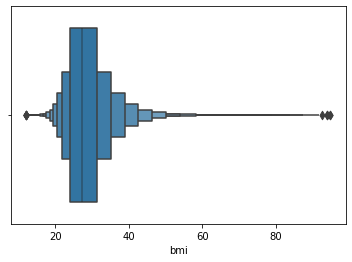

In [8]:
plt.figure(figsize=(6,4))
sns.boxenplot(x=df.bmi)
plt.show()

In [9]:
# The dict() function creates a dictionary. 
# A dictionary is a collection which is unordered, changeable and indexed.
# The function (_df.isnull().sum()_) returns the number of missing values in the dataset.
# The str() method returns the string representation of a given object.
nan_percentage_dict = dict()
print('NaN percentage for each column : ')
name = []
percentage = []
for i in df.columns:
    name.append(i)
    s = (str((df[i].isnull().sum()/df.shape[0]*100).round(2))+'%')
    percentage.append(s)
nan_percentage_dict['name'] = name
nan_percentage_dict['percentage'] = percentage
nan_percentage_df = pd.DataFrame(nan_percentage_dict)
display(nan_percentage_df)

NaN percentage for each column : 


,name,percentage
0,heartdisease,0.0%
1,bmi,0.0%
2,smoking,0.0%
3,alcoholdrinking,0.0%
4,stroke,0.0%
5,physicalhealth,0.0%
6,mentalhealth,0.0%
7,diffwalking,0.0%
8,sex,0.0%
9,agecategory,0.0%


In [10]:
bins = [0, 18.5, 25, 30, 35, np.inf]
names = ['Underweight (BMI < 18.5)', 'Normal weight (18.5 <= BMI < 25.0)', 'Overweight (25.0 <= BMI < 30.0)', 'Obese (30.0 <= BMI < 35.0)', 'Extremly Obese (BMI >= 35.0)']
df['bmi_category'] = pd.cut(df['bmi'], bins, labels=names)
df.drop('bmi',axis=1,inplace=True)

In [11]:
df['bmi_category'].value_counts()

Overweight (25.0 <= BMI < 30.0)       114355
Normal weight (18.5 <= BMI < 25.0)     97778
Obese (30.0 <= BMI < 35.0)             61169
Extremly Obese (BMI >= 35.0)           41379
Underweight (BMI < 18.5)                5114
Name: bmi_category, dtype: int64

In [12]:
# seperate numerical and categorical columns
numerical_cols = []
cat_cols = []
cols = df.columns
for i in range(len(cols)):
    if df[cols[i]].dtype == np.int64 or df[cols[i]].dtype == np.int32 or df[cols[i]].dtype == np.float64 or df[cols[i]].dtype == np.float32 :
        numerical_cols.append(cols[i])
    else :
        cat_cols.append(cols[i])

In [13]:
cat_cols

['heartdisease',
 'smoking',
 'alcoholdrinking',
 'stroke',
 'diffwalking',
 'sex',
 'agecategory',
 'race',
 'diabetic',
 'physicalactivity',
 'genhealth',
 'asthma',
 'kidneydisease',
 'skincancer',
 'bmi_category']

In [14]:
numerical_cols

['physicalhealth', 'mentalhealth', 'sleeptime']

In [15]:
# Check skewed featurs
name = []
skew_value_list = []
skew_type_list = list()
skew_dict = dict()
for i in numerical_cols :
    name.append(i)
    skew_value = skew(df[i])
    skew_value  = float("{:.3f}".format(skew_value))
    skew_value_list.append(skew_value)
    skew_type = ''
    if(skew_value == 0.0):
        skew_type  = 'no_skew'
    elif(skew_value > 0.0):
        skew_type = 'positive'
    else :
        skew_type = 'negative'
    skew_type_list.append(skew_type)

skew_dict['col_name'] = name
skew_dict['skew_value'] = skew_value_list
skew_dict['skew_type'] = skew_type_list
skew_df = pd.DataFrame(skew_dict)
display(skew_df)

,col_name,skew_value,skew_type
0,physicalhealth,2.604,positive
1,mentalhealth,2.331,positive
2,sleeptime,0.679,positive


In [16]:
# Function to plot the distribution of the skewed features
def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['physicalhealth','mentalhealth']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

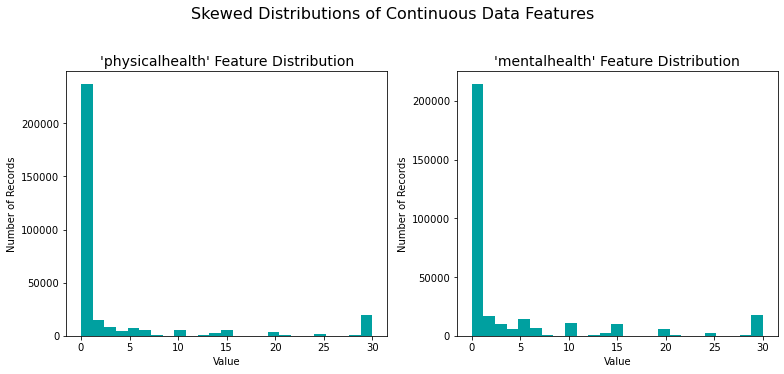

In [17]:
# Visualizing distribution of skewed data
distribution(df)

In [18]:
# transforming skewed data
df['physicalhealth'] = df['physicalhealth'].apply(lambda x: np.log(x + 1))
df['mentalhealth'] = df['mentalhealth'].apply(lambda x: np.log(x + 1))

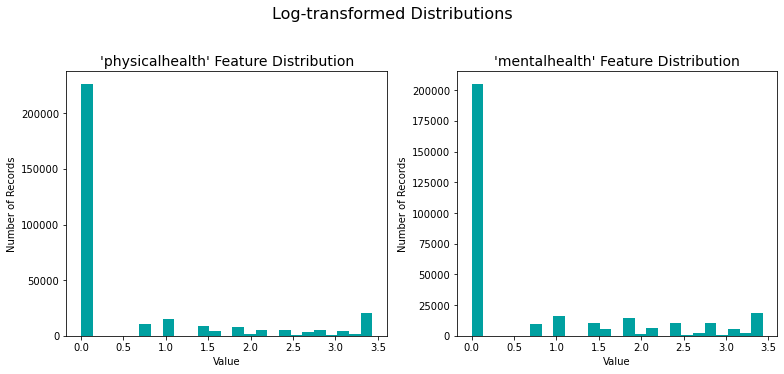

In [19]:
# Visualizing distribution of skewed data after transformation
distribution(df, transformed = True)

In [20]:
# Check skewed featurs
name = []
skew_value_list = []
skew_type_list = list()
skew_dict = dict()
for i in numerical_cols :
    name.append(i)
    skew_value = skew(df[i])
    skew_value  = float("{:.3f}".format(skew_value))
    skew_value_list.append(skew_value)
    skew_type = ''
    if(skew_value == 0.0):
        skew_type  = 'no_skew'
    elif(skew_value > 0.0):
        skew_type = 'positive'
    else :
        skew_type = 'negative'
    skew_type_list.append(skew_type)

skew_dict['col_name'] = name
skew_dict['skew_value'] = skew_value_list
skew_dict['skew_type'] = skew_type_list
skew_df = pd.DataFrame(skew_dict)
display(skew_df)

,col_name,skew_value,skew_type
0,physicalhealth,1.594,positive
1,mentalhealth,1.202,positive
2,sleeptime,0.679,positive


In [21]:
# counting values of categorical features
value_count_dict = dict()
for i in cat_cols:
    print(i,'column\'s count values : ' )
    index , count = df[i].value_counts().index , df[i].value_counts().values
    value_count_dict['value']  = list(index)
    value_count_dict['count'] = list(count)
    value_count_df = pd.DataFrame(value_count_dict)
    if value_count_df.shape[0]>10:
        display(value_count_df.head(10))
    else :
        display(value_count_df.head())

heartdisease column's count values : 


,value,count
0,No,292422
1,Yes,27373


smoking column's count values : 


,value,count
0,No,187887
1,Yes,131908


alcoholdrinking column's count values : 


,value,count
0,No,298018
1,Yes,21777


stroke column's count values : 


,value,count
0,No,307726
1,Yes,12069


diffwalking column's count values : 


,value,count
0,No,275385
1,Yes,44410


sex column's count values : 


,value,count
0,Female,167805
1,Male,151990


agecategory column's count values : 


,value,count
0,65-69,34151
1,60-64,33686
2,70-74,31065
3,55-59,29757
4,50-54,25382
5,80 or older,24153
6,45-49,21791
7,75-79,21482
8,18-24,21064
9,40-44,21006


race column's count values : 


,value,count
0,White,245212
1,Hispanic,27446
2,Black,22939
3,Other,10928
4,Asian,8068


diabetic column's count values : 


,value,count
0,No,269653
1,Yes,40802
2,"No, borderline diabetes",6781
3,Yes (during pregnancy),2559


physicalactivity column's count values : 


,value,count
0,Yes,247957
1,No,71838


genhealth column's count values : 


,value,count
0,Very good,113858
1,Good,93129
2,Excellent,66842
3,Fair,34677
4,Poor,11289


asthma column's count values : 


,value,count
0,No,276923
1,Yes,42872


kidneydisease column's count values : 


,value,count
0,No,308016
1,Yes,11779


skincancer column's count values : 


,value,count
0,No,289976
1,Yes,29819


bmi_category column's count values : 


,value,count
0,Overweight (25.0 <= BMI < 30.0),114355
1,Normal weight (18.5 <= BMI < 25.0),97778
2,Obese (30.0 <= BMI < 35.0),61169
3,Extremly Obese (BMI >= 35.0),41379
4,Underweight (BMI < 18.5),5114


## Data visualization

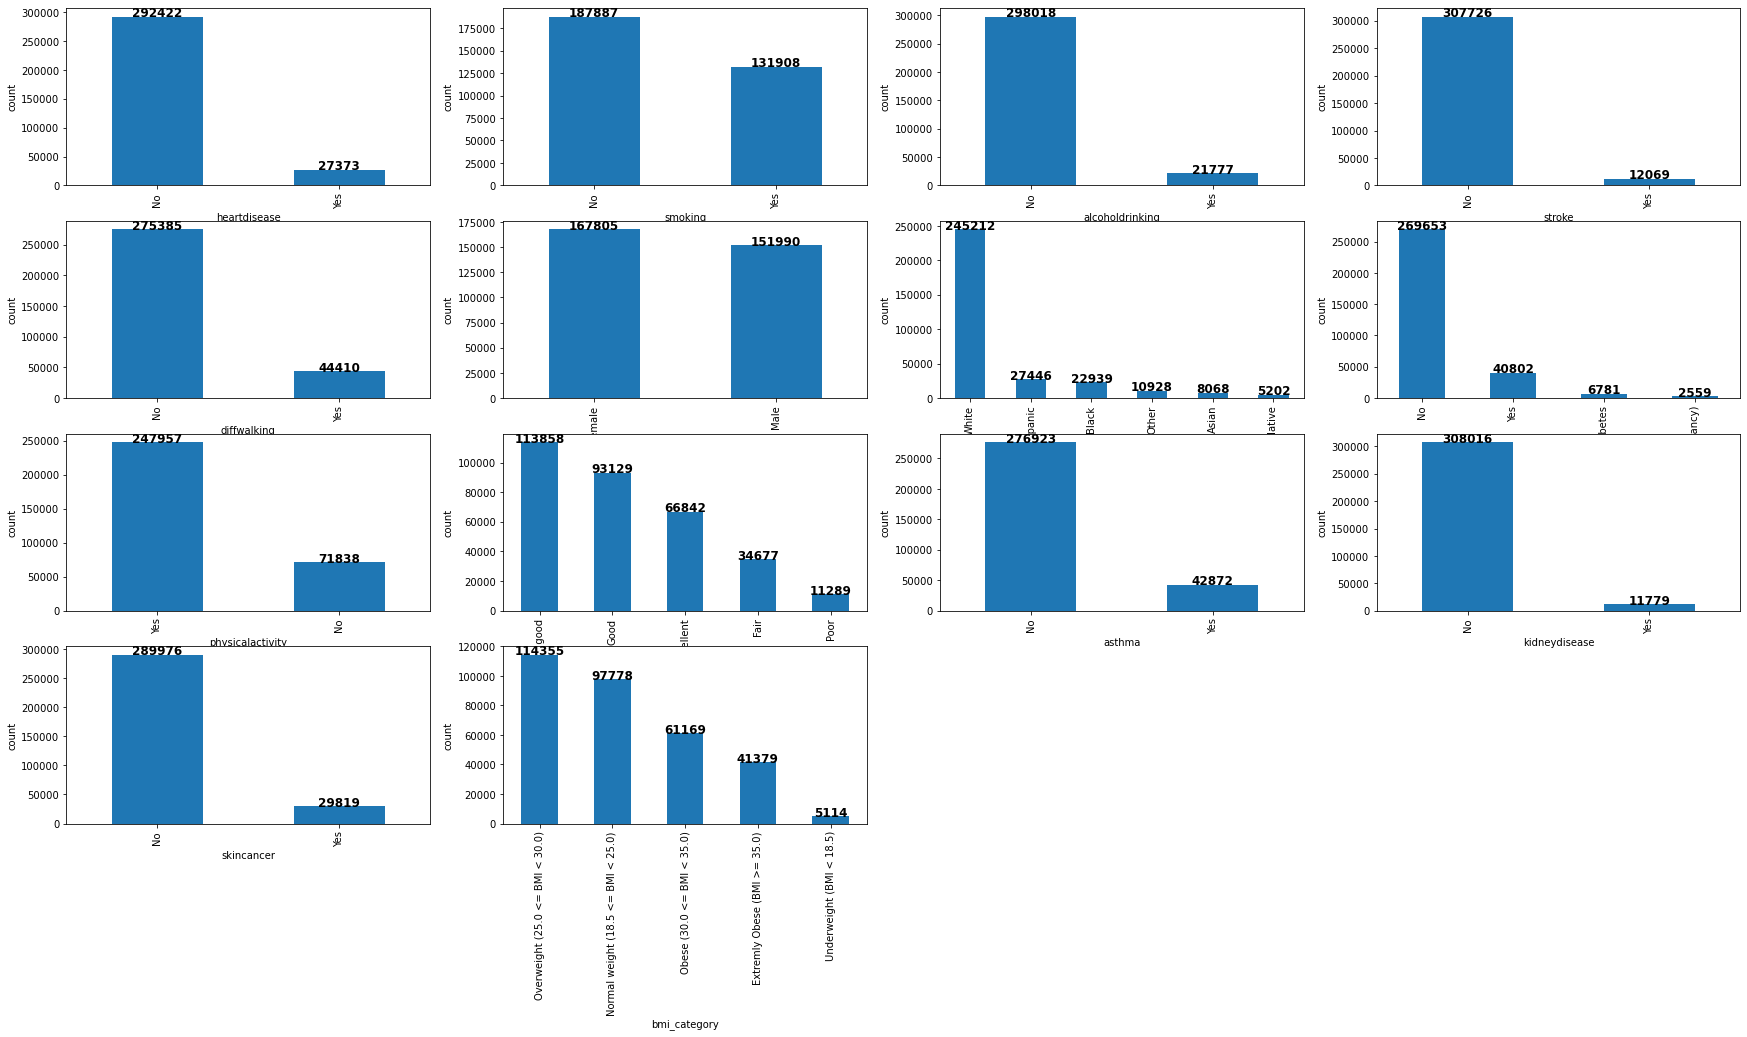

In [22]:
# Bar plotting for categorical values
if (len(cat_cols) <= 4 ) :#on one line  # to adjust figure size
    plt.figure(figsize = (30,7))
else:
    plt.figure(figsize = (30,15))
rows = len(cat_cols)//4
cat_col_bar = []
for i in cat_cols :
    if len(df[i].unique())<=10:
        cat_col_bar.append(i)        
for index , i in enumerate(cat_col_bar):
    ax = plt.subplot( rows+1 , 4, index+1)
    (df[i].value_counts()).plot.bar()
    ax.set_xlabel(i)
    ax.set_ylabel("count")
    for patch in ax.patches:
        loc = patch.get_x()
        width = patch.get_width()
        height = patch.get_height()
        ax.text(loc+width/2, height, str(height), fontsize=12, weight='bold', ha='center')
        
plt.show();

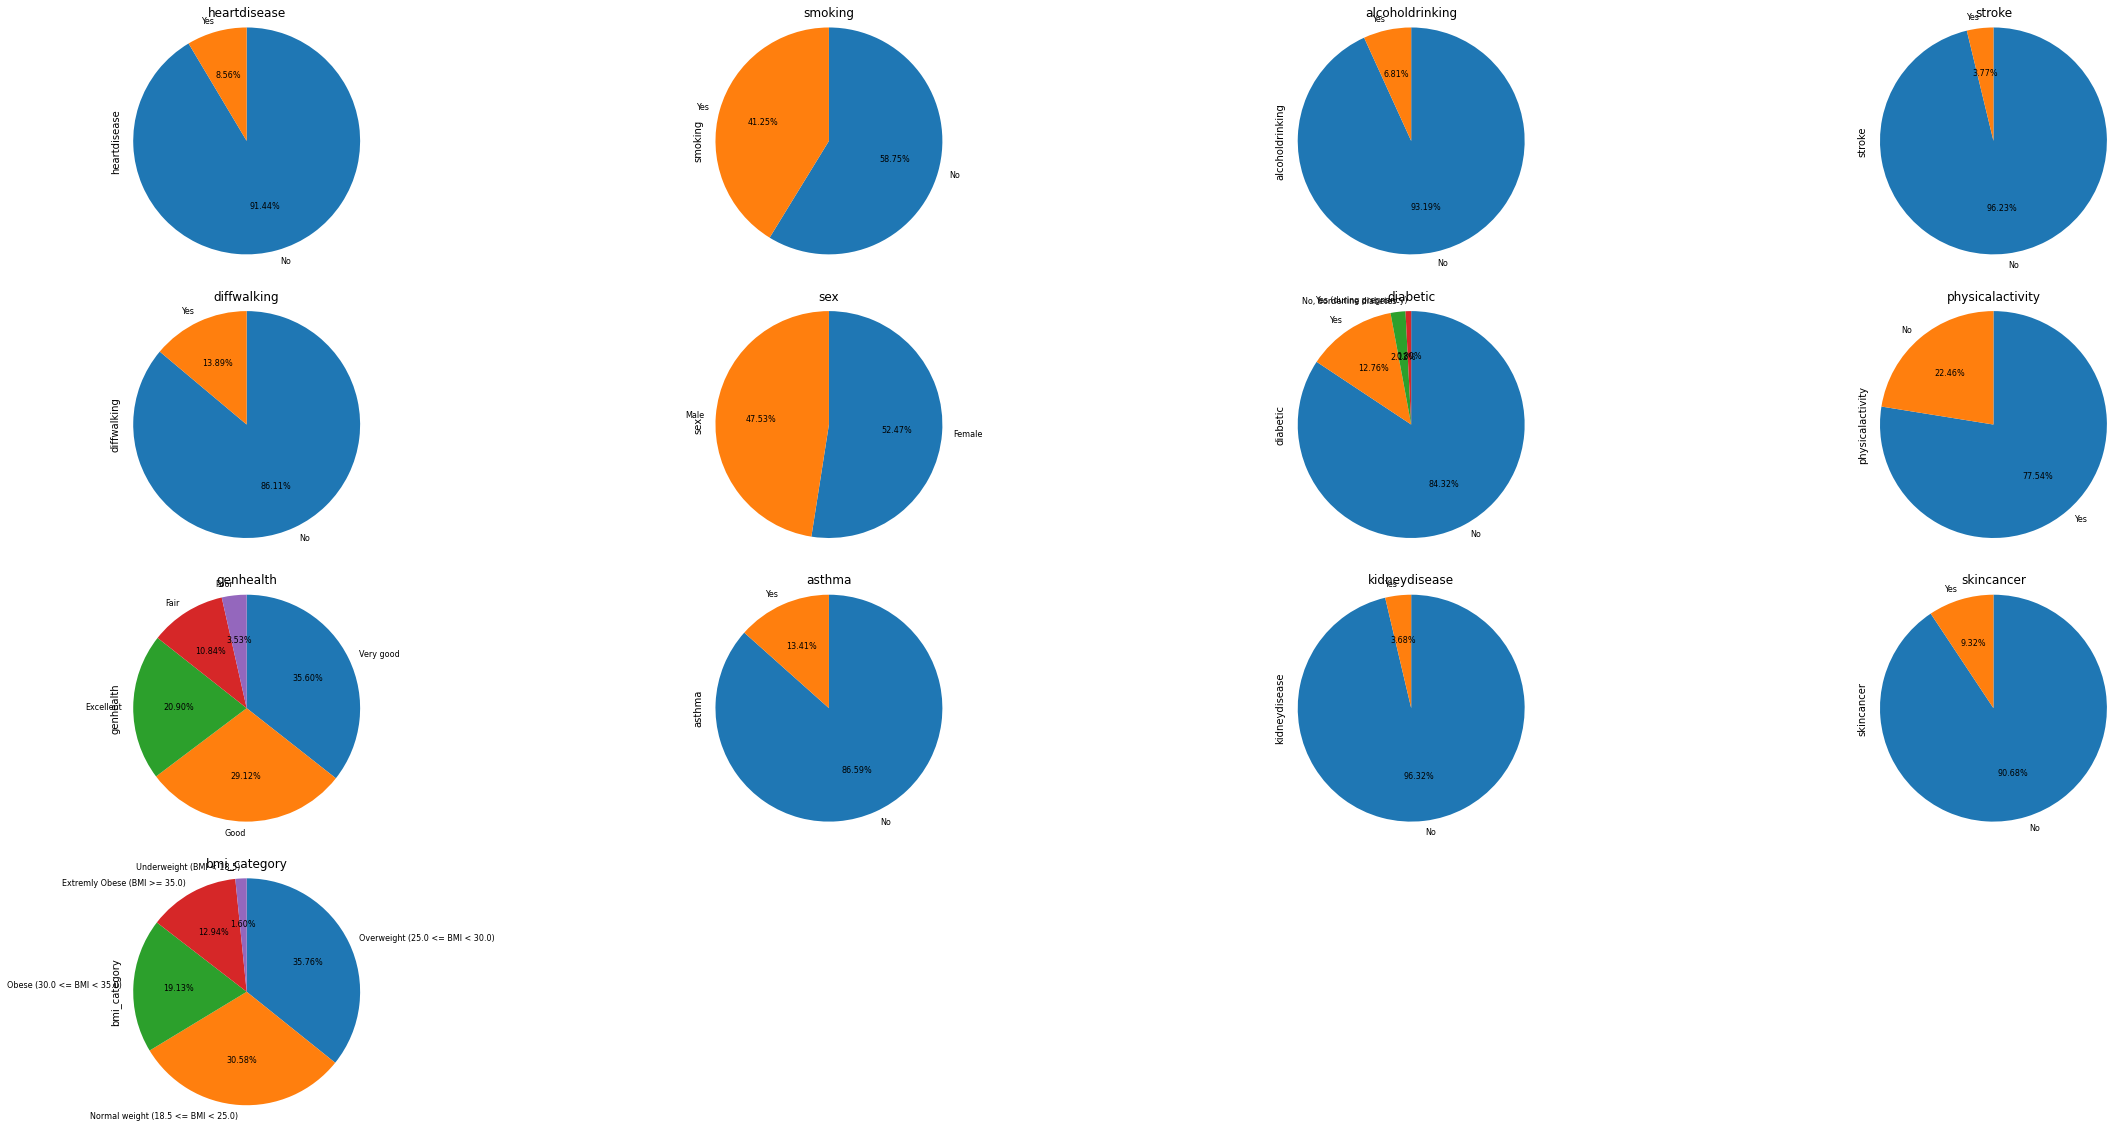

In [23]:
# Pie plots for categorical values
plt.figure(figsize = (40,20))
rows = len(cat_cols)//4
cat_col_pie = []
for i in (cat_cols) :
    if len(df[i].unique())<=5: # we want to draw pie for columns with min unique values = 5
        cat_col_pie.append(i)

for index , i in enumerate(cat_col_pie):
    ax = plt.subplot( rows+1 , 4, index+1)
    val_count = df[i].value_counts()
    (df[i].value_counts()).plot.pie(autopct='%.2f%%',labels=val_count.index,startangle=90,counterclock=False , radius=1.2, textprops={'fontsize':8})
    plt.title(i)
plt.show() 

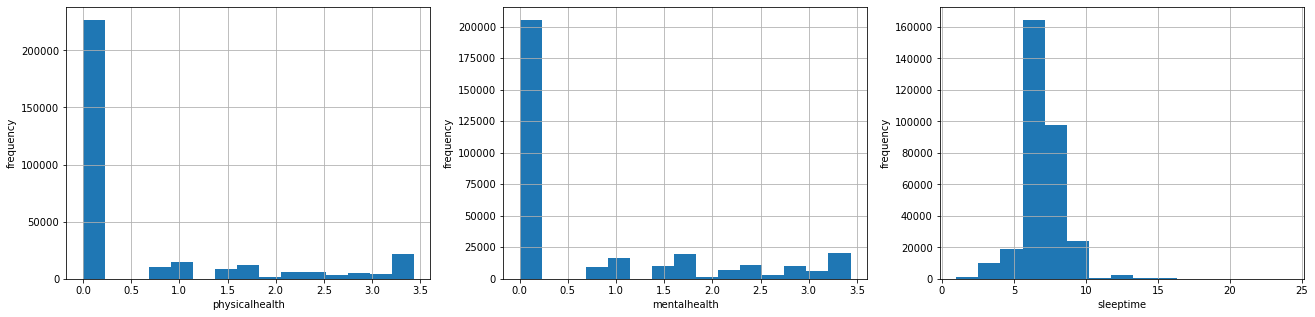

In [24]:
# Histograms for numerical values
if (len(numerical_cols) <= 4 ) :#on one line
    plt.figure(figsize = (30,5))
else:
    plt.figure(figsize = (30,5))           
rows = len(numerical_cols)//4
for index , i in enumerate(numerical_cols):
    ax = plt.subplot( rows+1 , 4, index+1)
    df[i].hist(bins = 15)
    ax.set_xlabel(i)
    ax.set_ylabel('frequency')

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


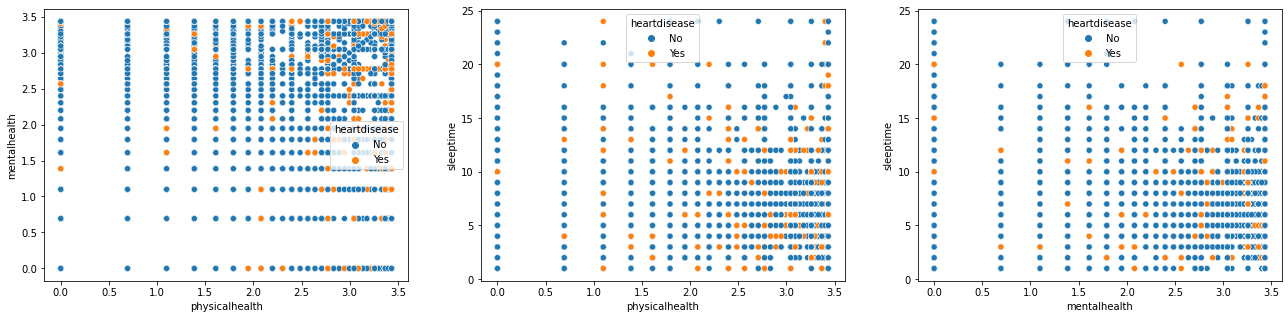

In [25]:
#bivarite plots :
if len(numerical_cols) > 4:
    plt.figure(figsize=(30,5)) 
    plt.tight_layout(pad = 15)
    for iterate in range(1,17):
        ax = plt.subplot( 4 , 4, iterate )
        i = np.random.randint(len(numerical_cols))
        j = np.random.randint(len(numerical_cols))
        sns.scatterplot(data=df, x=numerical_cols[i], y=numerical_cols[j],ax = ax, hue = 'heartdisease')
        ax.set_xlabel(numerical_cols[i])
        ax.set_ylabel(numerical_cols[j])  
else :
    index = 1
    plt.figure(figsize = (30,5))
    plt.tight_layout(pad = 5)
    rows = (np.math.factorial(len(numerical_cols)-1))//4
    for i in range(len(numerical_cols)-1):
        for j in range(i+1 ,len(numerical_cols)):
            #print(i , j , (i+1)*j)
            ax = plt.subplot( rows+1 , 4, index )
            index+=1

            sns.scatterplot(data=df, x=numerical_cols[i], y=numerical_cols[j],ax = ax, hue = 'heartdisease')
            ax.set_xlabel(numerical_cols[i])
            ax.set_ylabel(numerical_cols[j])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


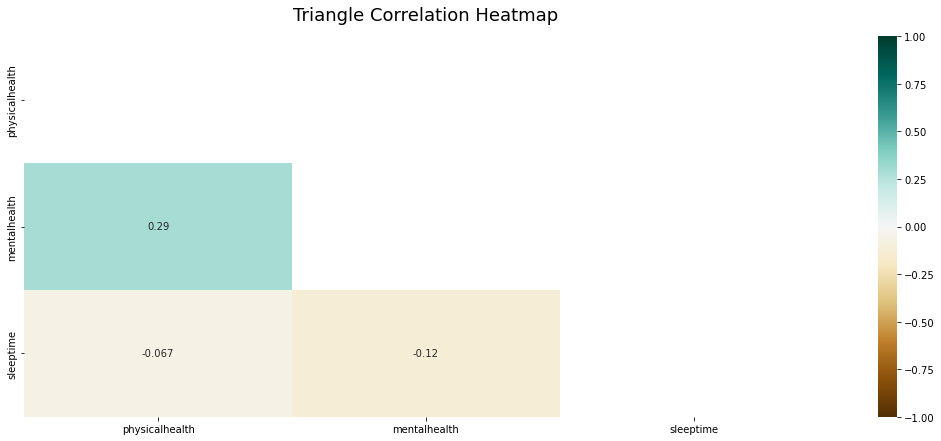

In [26]:
# Triangel heatmap
plt.figure(figsize=(18, 7))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show();

In [27]:
def boxplot_draw(df, cat_col, numerical_col):
    """
    Function to draw boxplots for categorical features in a given dataset.

    Parameters:
    df (pandas DataFrame): The dataset.
    cat_col (list): List of categorical column names.
    numerical_col (list): List of numerical column names.
    """
    # Select categorical columns with less than or equal to 10 unique values
    cat_col_unique_less = [col for col in cat_col if len(df[col].unique()) <= 10]
    
    # Total number of plots to be generated
    total = len(numerical_col) * len(cat_col_unique_less)
    
    # Set figure size based on number of plots
    if total > 4:
        plt.figure(figsize=(40, 30))
        plt.tight_layout(pad=15)
    else:
        plt.figure(figsize=(30, 5))
        plt.tight_layout(pad=5)
    
    # Draw boxplots
    index = 1
    for i in range(len(cat_col_unique_less)):
        for j in range(len(numerical_col)):  
            ax = plt.subplot((total // 4) + 1, 4, index)
            sns.boxplot(x=cat_col_unique_less[i], y=numerical_col[j], data=df)
            ax.set_xlabel(cat_col_unique_less[i], fontsize=18, fontweight='bold')
            plt.xticks(rotation=45)
            ax.set_ylabel(numerical_col[j], fontsize=18, fontweight='bold') 
            index += 1

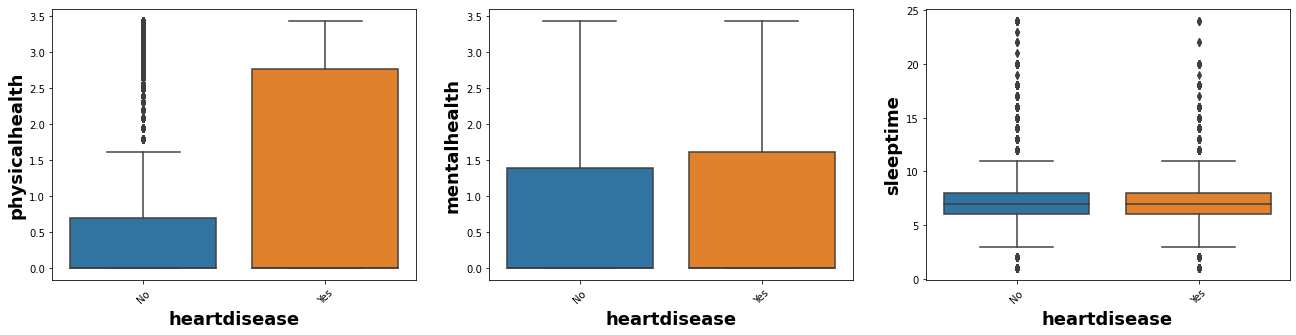

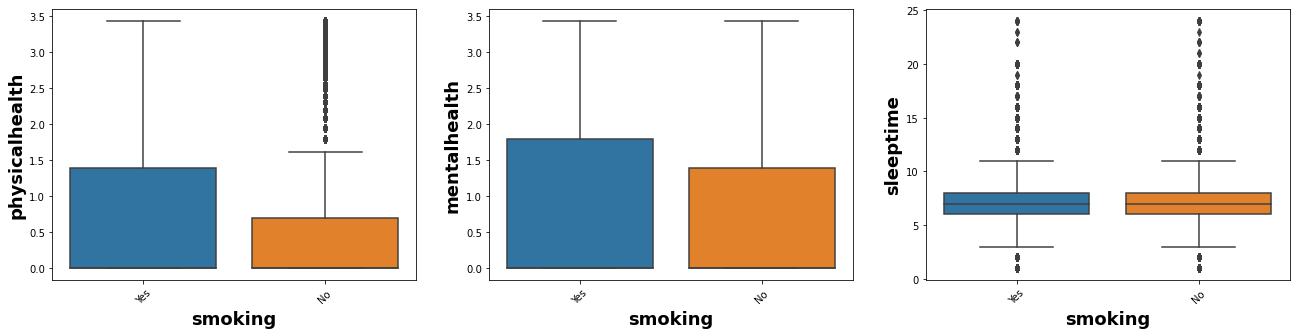

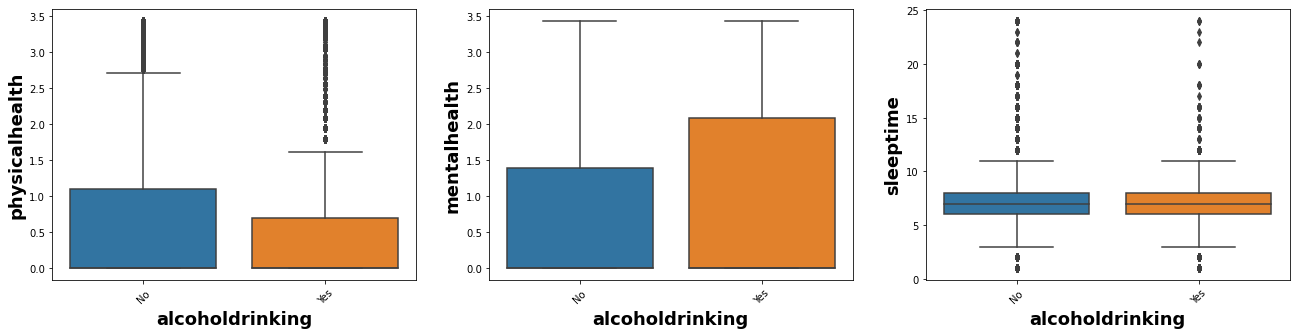

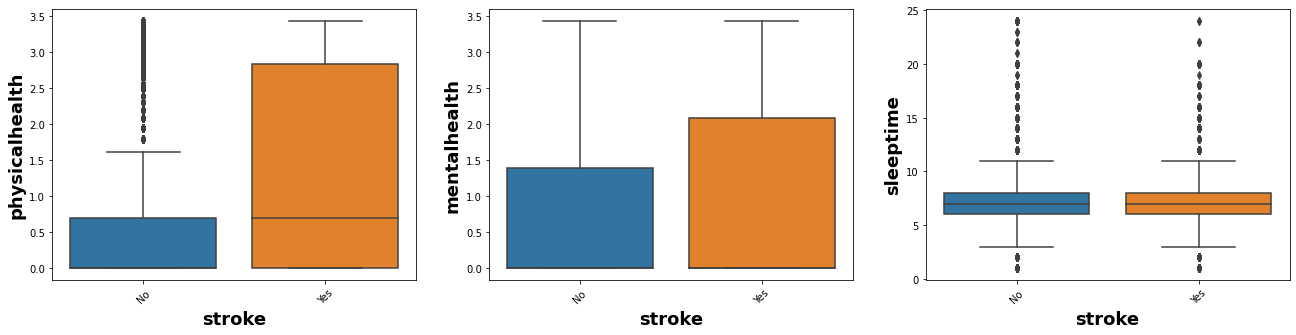

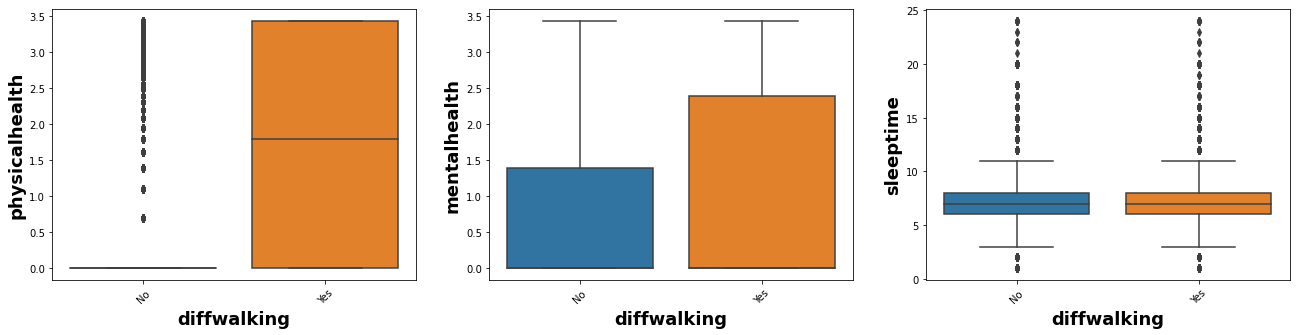

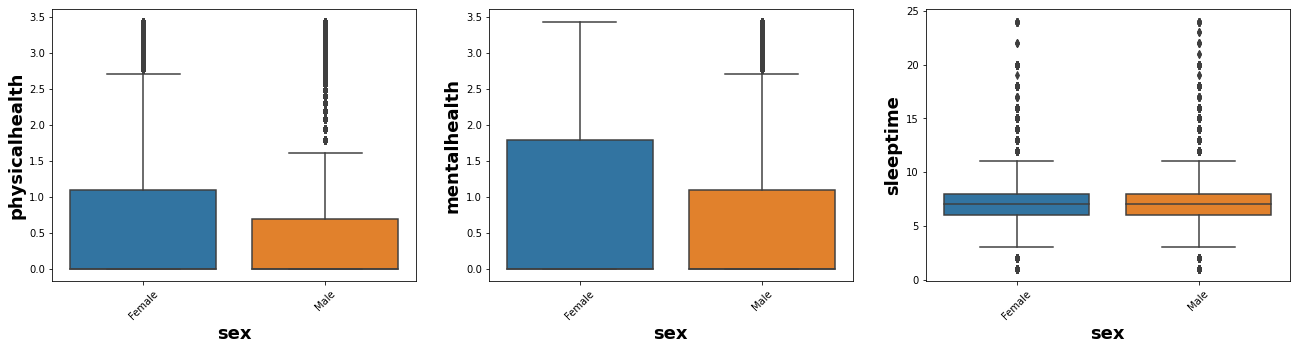

<Figure size 2160x360 with 0 Axes>

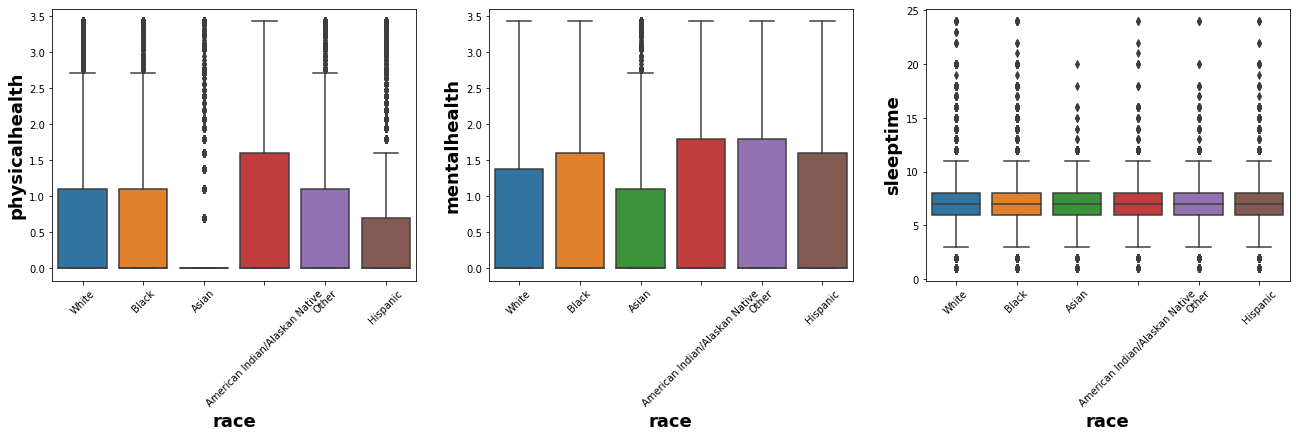

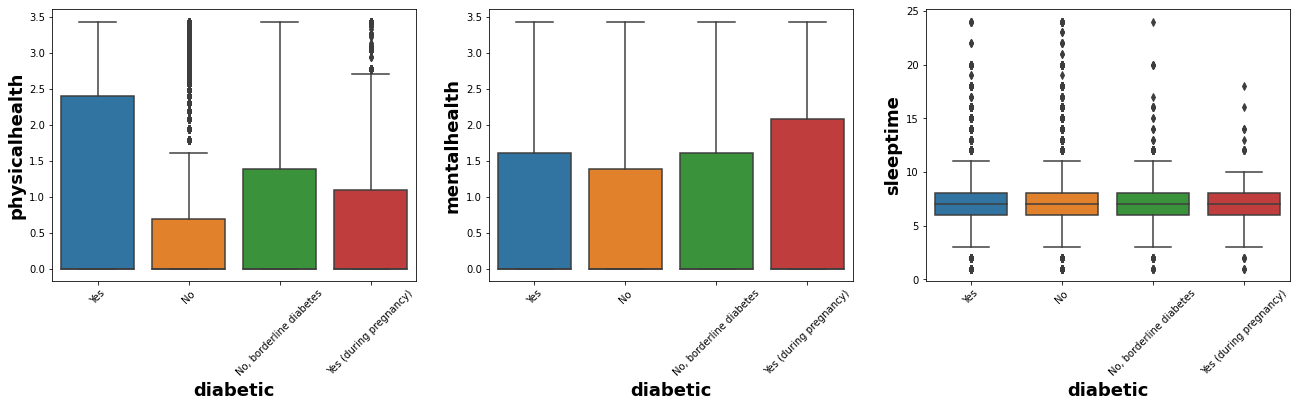

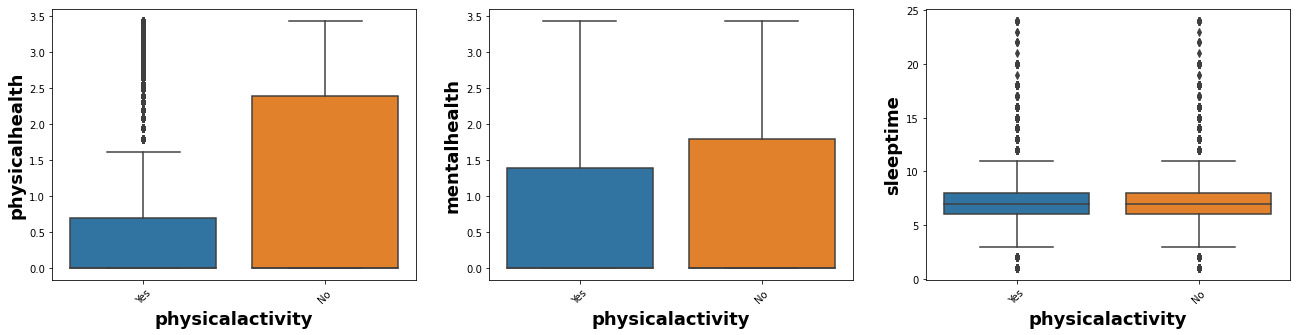

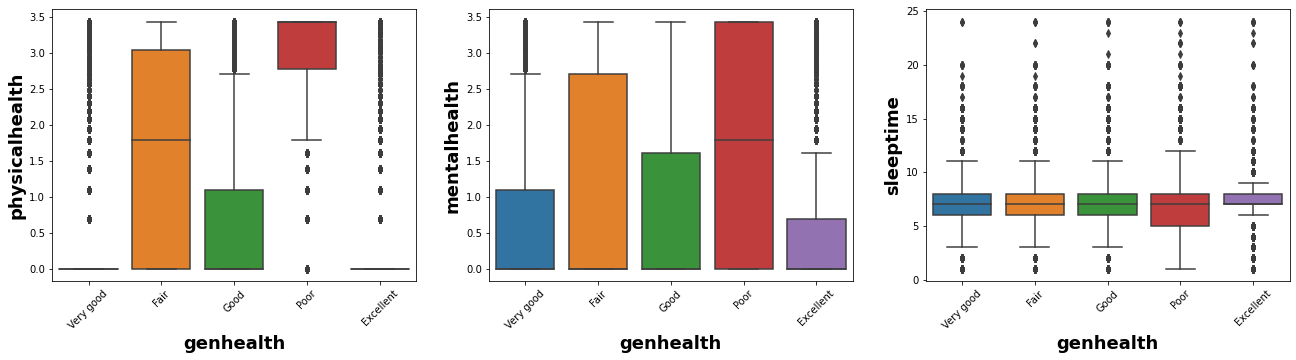

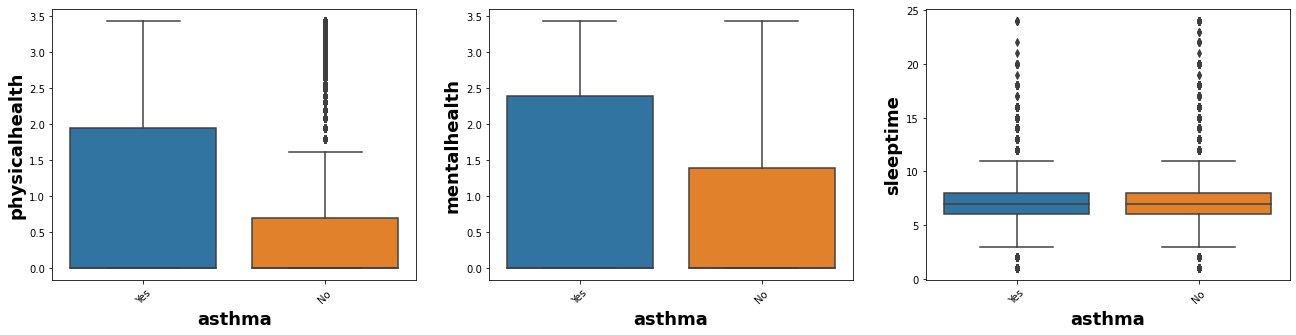

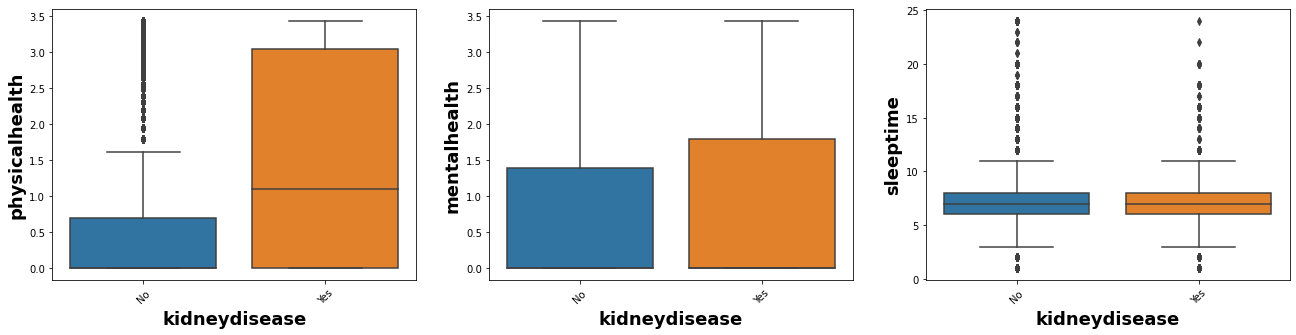

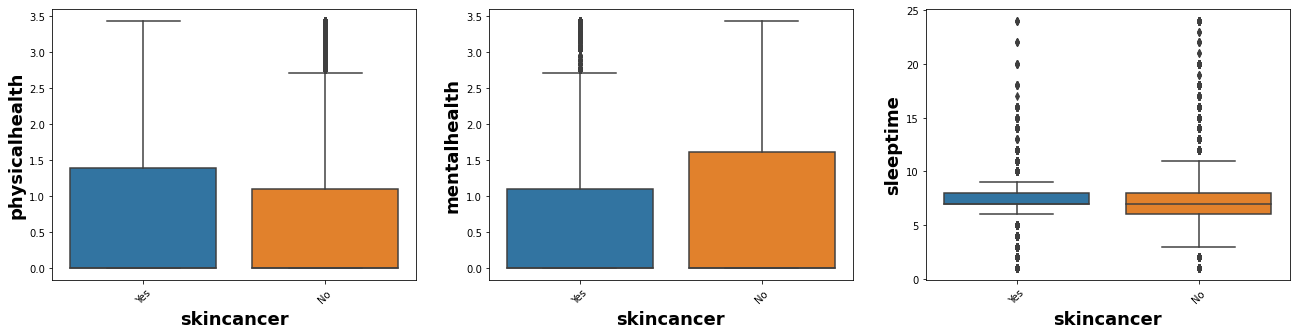

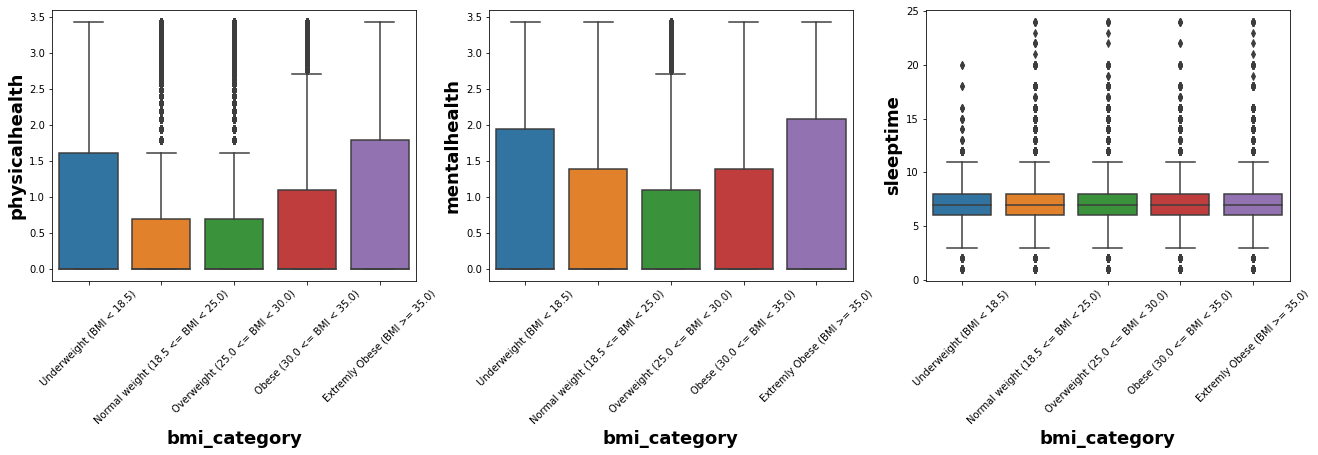

In [28]:
# Draw boxplots for categorical features
for col in cat_cols:
    boxplot_draw(df, [col], numerical_cols)

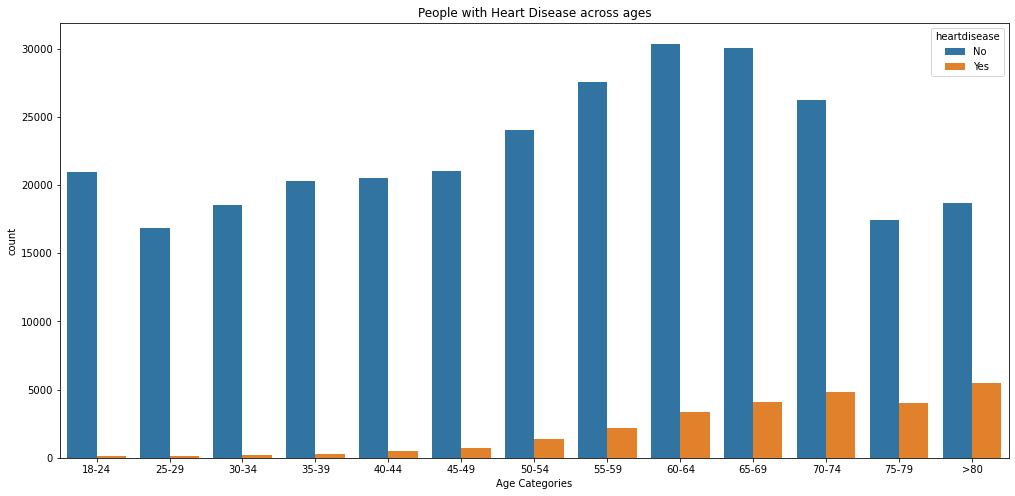

In [29]:
# Change the value of agecategory from "80 or older" to ">80"
df.loc[df.agecategory == '80 or older', 'agecategory'] = '>80'

# Get unique values of agecategory and sort it
order = pd.unique(df.agecategory.values)
order.sort()

# Set the figure size
plt.figure(figsize=(17, 8))

# Draw the countplot of agecategory and heartdisease
sns.countplot(data=df, x='agecategory', hue='heartdisease', order=order)

# Set the title of the plot
plt.title('People with Heart Disease across ages')

# Set the x-axis label
plt.xlabel('Age Categories')

# Show the plot
plt.show()

## Feature Engineering

In [30]:
# Sorted unique values of the dataframe
df.nunique().sort_values(ascending=False)

physicalhealth      31
mentalhealth        31
sleeptime           24
agecategory         13
race                 6
genhealth            5
bmi_category         5
diabetic             4
sex                  2
diffwalking          2
smoking              2
physicalactivity     2
stroke               2
alcoholdrinking      2
asthma               2
kidneydisease        2
skincancer           2
heartdisease         2
dtype: int64

In [31]:
# Number of duplicated rows
print(f'Nubmer of duplicated recrods = {df.duplicated().sum()}')

Nubmer of duplicated recrods = 119501


In [32]:
# Get list of columns that contain 'Yes' and 'No'
cols_with_yes_no = [col for col in df.columns if set(df[col].unique()).issubset({'Yes', 'No'})]
print(cols_with_yes_no)

['heartdisease', 'smoking', 'alcoholdrinking', 'stroke', 'diffwalking', 'physicalactivity', 'asthma', 'kidneydisease', 'skincancer']


In [33]:
# Replace 'Yes' with 1 and 'No' with 0 for selected columns
df[cols_with_yes_no] = df[cols_with_yes_no].replace({'Yes': 1, 'No': 0})

In [34]:
# encode the data
labelencoder = LabelEncoder()

order_cols = ["bmi_category", "agecategory"]
no_order_cols = ["sex", "race", "diabetic","genhealth"]

# Label encoding
for col in order_cols:
    df[col] = labelencoder.fit_transform(df[col])

# One-hot encoding
for col in no_order_cols:
    dummy_col = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummy_col], axis=1)
    del df[col]

In [35]:
X = df.drop(['heartdisease'], axis=1)
y = df['heartdisease']

## Feature  selection

In [36]:
#Chi-square Test
# Convert to categorical data by converting data to integers
X_cat = X.astype (int)

# Three features with highest chi-squared statistics are selected
chi2_features = SelectKBest (chi2, k = 3)
X_kbest_features = chi2_features.fit_transform(X_cat, y)

# Reduced features
print('Original feature number:', X_cat.shape[1])
print('Reduced feature number:', X_kbest_features.shape [1])

Original feature number: 30
Reduced feature number: 3


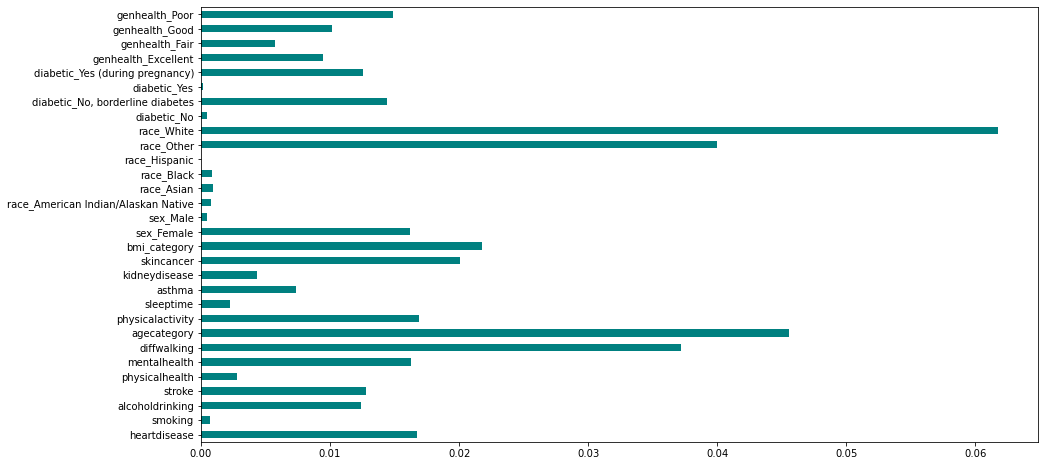

In [37]:
#Information Gain
plt.figure(figsize = (15,8))
importances = mutual_info_classif(X, y)
feat_importances = pd.Series (importances, df.columns [0:len (df.columns)-1])
feat_importances.plot(kind='barh', color= 'teal')
plt.show()

Index(['heartdisease', 'diffwalking', 'agecategory'], dtype='object')

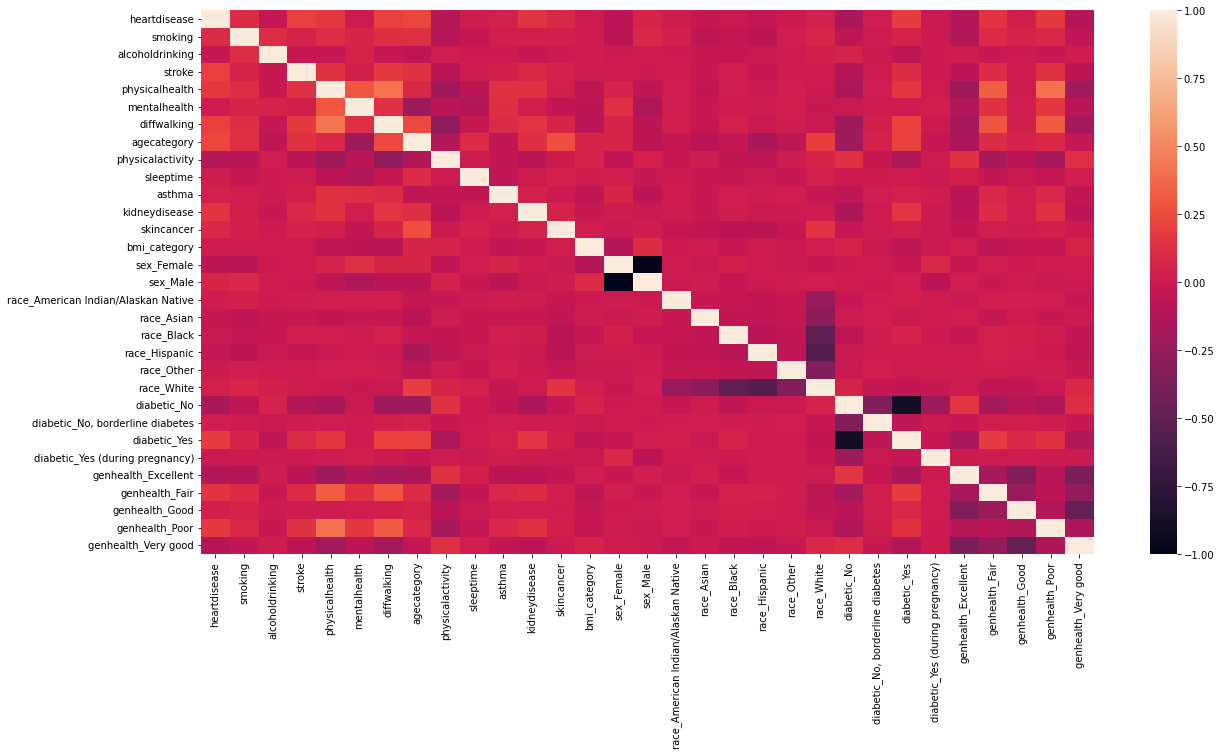

In [38]:
# Calculate the correlation matrix of the dataframe
cor = df.corr()

# Set the figure size
plt.figure(figsize=(20, 10))

# Draw the heatmap of the correlation matrix
sns.heatmap(cor)

# Get the correlation values between the target feature "heartdisease" and other features
cor_target = abs(cor["heartdisease"])

# Select the features that have a correlation value greater than 0.2 with the target feature
relevant_features = cor_target[cor_target > 0.2]

# Get the index of the selected relevant features
relevant_features.index

In [39]:
#Univariate Feature Selection
# Select the top 5 best features using f_classif scoring method
uni = SelectKBest(score_func = f_classif, k = 5)

# Fit the SelectKBest to X and y
fit = uni.fit(X, y)

# Get the list of columns of the selected 5 best features
X.columns[fit.get_support(indices=True)].tolist()



['stroke', 'diffwalking', 'agecategory', 'diabetic_Yes', 'genhealth_Poor']

In [40]:
#Wrapper Method
# Add a constant to X
X_new = sm.add_constant(X)

# Fit OLS model to X_new and y
model = sm.OLS(y, X_new).fit()

# Get the p-values of the model
p_values = model.pvalues

display(p_values)

const                                   1.332962e-07
smoking                                 7.909297e-99
alcoholdrinking                         3.832712e-16
stroke                                  0.000000e+00
physicalhealth                          7.546111e-13
mentalhealth                            3.476723e-01
diffwalking                            6.525722e-114
agecategory                             0.000000e+00
physicalactivity                        7.415212e-01
sleeptime                               1.161462e-01
asthma                                  7.077382e-29
kidneydisease                           0.000000e+00
skincancer                              7.565684e-53
bmi_category                            2.538564e-02
sex_Female                              2.184865e-99
sex_Male                               5.398211e-199
race_American Indian/Alaskan Native     2.656473e-02
race_Asian                              3.739585e-01
race_Black                              2.6962

In [41]:
# Initialize a list to store selected features
selected_features = list(X.columns)

# Initialize a variable to store the maximum p-value
pmax = 1

# Perform feature selection using Wrapper Method
while (len(selected_features) > 0):
    # Initialize a list to store p-values
    p = []
    
    # Select the current subset of features
    X_new = X[selected_features]
    
    # Add a constant to X_new
    X_new = sm.add_constant(X_new)
    
    # Fit a linear regression model
    model = sm.OLS(y, X_new).fit()
    
    # Get p-values from the model
    p = pd.Series(model.pvalues.values[1:], index=selected_features)
    
    # Get the maximum p-value
    pmax = max(p)
    
    # Get the feature with the maximum p-value
    feature_pmax = p.idxmax()
    
    # If the maximum p-value is greater than 0.05, remove the feature from the list of selected features
    if pmax > 0.05:
        selected_features.remove(feature_pmax)
    else:
        break

# Print the list of selected features
selected_features

['smoking',
 'alcoholdrinking',
 'stroke',
 'physicalhealth',
 'diffwalking',
 'agecategory',
 'asthma',
 'kidneydisease',
 'skincancer',
 'bmi_category',
 'sex_Female',
 'sex_Male',
 'race_American Indian/Alaskan Native',
 'race_Black',
 'race_Other',
 'race_White',
 'diabetic_No',
 'diabetic_No, borderline diabetes',
 'diabetic_Yes',
 'diabetic_Yes (during pregnancy)',
 'genhealth_Excellent',
 'genhealth_Fair',
 'genhealth_Good',
 'genhealth_Poor',
 'genhealth_Very good']

In [42]:
X_selected = df[selected_features]

In [43]:
X.shape

(319795, 30)

In [44]:
X_selected.shape

(319795, 25)

In [45]:
y_selected = df['heartdisease']

In [46]:
# oversampling using SMOTE
over = SMOTE(k_neighbors=2000)
X, y = over.fit_resample(X, y)

In [47]:
over_selected = SMOTE(k_neighbors=2000)
X_selected, y_selected = over_selected.fit_resample(X_selected, y_selected)

In [48]:
# Split the data
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [49]:
np.random.seed(42)
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.3)

## Training and testing

In [50]:
def compare_models(X, y, X_selected, y_selected, algorithm, max_iter=None):
    """
    Parameters:
    X (pandas DataFrame): The feature dataset.
    y (pandas Series): The target dataset.
    X_selected (pandas DataFrame): columns to use as the subset dataset.
    y_selected (pandas Series): The target dataset.
    algorithm: The machine learning algorithm to use for training.
    max_iter (Intger): Number of iterations.
    """

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

    # If number of iertations provided
    if max_iter:
        model = algorithm(max_iter=max_iter)
    else:
        model = algorithm()

    # Train the model on the original dataset
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    original_acc = accuracy_score(y_test, y_pred)
    original_f1 = f1_score(y_test, y_pred)
    original_precision = precision_score(y_test, y_pred)
    original_recall = recall_score(y_test, y_pred)
    print('Metrics on test original data: ')
    print('original accuracy: ', original_acc)
    print('Original F1: ', original_f1 ) # Harmonic mean of precisin and recall
    print('original_precision: ', original_precision) # Positive predictive value
    print('original_recall: ', original_recall) # sensitivity measuement metric

    # confusion matrix for original data
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(4, 4))
    plt.title("Confusion Matrix on Original Dataset")

    # If number of iertations provided
    if max_iter:
        model_selected = algorithm(max_iter=max_iter)
    else:
        model_selected = algorithm()

    # Train the model on the subset dataset
    model_selected.fit(X_train_selected, y_train_selected)
    y_pred_selected = model_selected.predict(X_test_selected)
    selected_acc = accuracy_score(y_test_selected, y_pred_selected)
    selected_f1 = f1_score(y_test_selected, y_pred_selected)
    selected_precision = precision_score(y_test_selected, y_pred_selected)
    selected_recall = recall_score(y_test_selected, y_pred_selected)
    print('')
    print('Metrics on test subset data: ')
    print('selected_acc: ', selected_acc)
    print('selected_f1: ', selected_f1 ) # Harmonic mean of precisin and recall
    print('selected_precision: ', selected_precision) # Positive predictive value
    print('selected_recall: ', selected_recall) # sensitivity measuement metric

    # confusion matrix for subset data
    cm = confusion_matrix(y_test_selected, y_pred_selected, labels=model_selected.classes_)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(4, 4))
    plt.title("Confusion Matrix on Subset Dataset")
    plt.show()

Metrics on test original data: 
original accuracy:  0.9263394574630885
Original F1:  0.9239661836601423
original_precision:  0.9547178757705074
original_recall:  0.8951337117844197

Metrics on test subset data: 
selected_acc:  0.8943993707734528
selected_f1:  0.8914128982347562
selected_precision:  0.9173481942534559
selected_recall:  0.8669037685520826


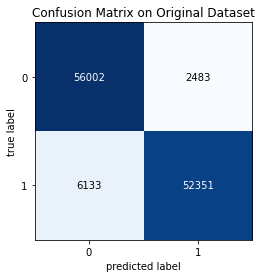

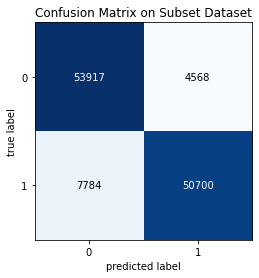

In [51]:
# Train the original and reduced datasets on RandomForestClassifier and compare between results
compare_models(X, y, X_selected, y_selected, RandomForestClassifier)

Metrics on test original data: 
original accuracy:  0.9420444733219913
Original F1:  0.9393405216768826
original_precision:  0.9853015712113533
original_recall:  0.8974762328158129

Metrics on test subset data: 
selected_acc:  0.9107712299840128
selected_f1:  0.9070506826257715
selected_precision:  0.9465085590022861
selected_recall:  0.8707509746255386


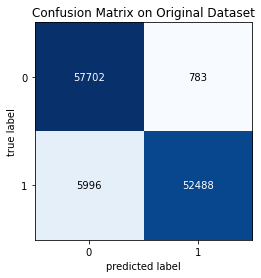

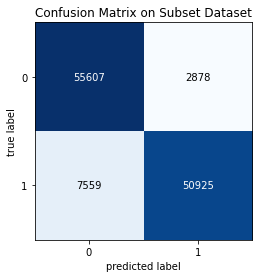

In [52]:
#Train the original and reduced datasets on XGBClassifier and compare between results
compare_models(X, y, X_selected, y_selected, XGBClassifier)

Metrics on test original data: 
original accuracy:  0.8989561336764442
Original F1:  0.8936231492732101
original_precision:  0.943406624731571
original_recall:  0.8488304493536694

Metrics on test subset data: 
selected_acc:  0.8805922936846515
selected_f1:  0.8750838468487001
selected_precision:  0.9173964408273483
selected_recall:  0.8365022912249505


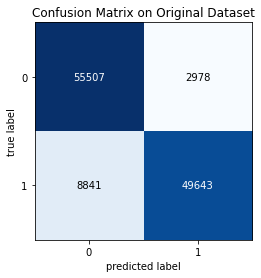

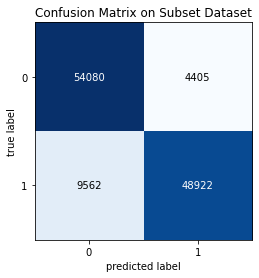

In [53]:
#Train the original and reduced datasets on LogisticRegression and compare between results
compare_models(X, y, X_selected, y_selected, LogisticRegression, 1000)

In [54]:
#Train the original and reduced datasets on SVC and compare between results
#compare_models(X, y, X_selected, y_selected, SVC)

In [55]:
#Train the original and reduced datasets on Knn and compare between results
#compare_models(X, y, X_selected, y_selected, KNeighborsClassifier)

In [56]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show();

In [57]:
# Usding AdaBoostClassifier to get feature_importances_ for the original data
model = AdaBoostClassifier().fit(X_train, y_train)
importances = model.feature_importances_

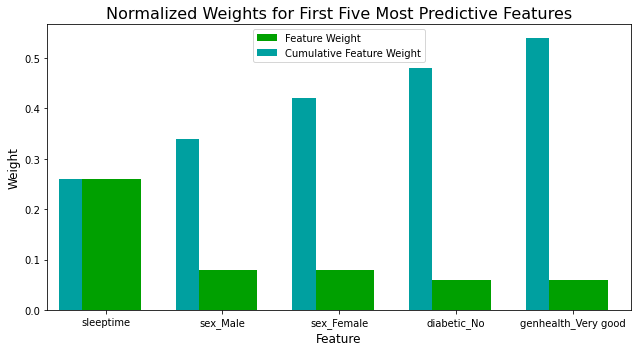

In [58]:
# Plot the highest feature importace of original data
feature_plot(importances, X_train, y_train)

In [59]:
# Usding AdaBoostClassifier to get feature_importances_ for the reduced data
model_selected = AdaBoostClassifier().fit(X_train_selected, y_train_selected)
importances_selected = model_selected.feature_importances_

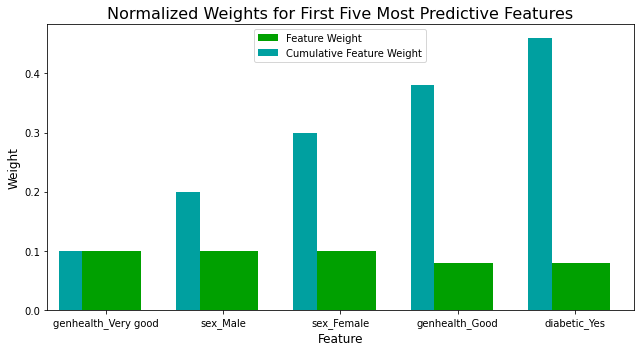

In [60]:
# Plot the highest feature importace of subset data
feature_plot(importances_selected, X_train_selected, y_train_selected)